In [ ]:
# pip install umap-learn hdbscan


In [3]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE

from umap import UMAP
import hdbscan

In [11]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    X_all, labels_true = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    X_all, labels_true = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            X_all = np.vstack([X_all, feature_extractor(x.cuda()).cpu()])
            labels_true = np.concatenate([labels_true, y])
    np.savez(filename, f_all=labels_true, y_all=labels_true)

In [12]:
print(X_all.shape, labels_true.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


### QUESTION 19:
- <font color='red'>In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?

Convolutional neural networks (CNNs) consist of two main parts: one that extracts features from RGB images using convolutional filters, and another that classifies these features using a fully-connected neural network. In VGG networks, early layers learn simple features like edges, while later layers focus on complex shapes and object parts. Features learned by CNNs, especially lower-level ones, are generally versatile and useful for different datasets, making them suitable for tasks like clustering. Pre-trained CNNs act as experienced agents adept at recognizing key features for image understanding.


### QUESTION 20:
- <font color='red'>In a brief paragraph explain how the helper code base is performing feature extraction.

First, it defines a FeatureExtractor class that encapsulates specific layers of the VGG-16 model necessary for feature extraction, including convolutional (features), average pooling (pooling), flattening (flatten), and the first fully-connected layer (fc). Then, it sets up an image dataset (ImageFolder) from the flower_photos directory with defined transformations for resizing, center cropping, and normalization. Using a DataLoader, the code iterates through batches of images, applies the FeatureExtractor to extract features from each image batch, and accumulates these features (f_all) along with corresponding labels (y_all).


### QUESTION 21:
- <font color='red'>How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?

There are 32400 = 180*180 pixels in the original image. Dimension of the each image after using VGG network reduced to 4096.


### QUESTION 22:
- <font color='red'>Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.)

When we use the VGG-16 model as a feature extractor, it processes each input image through its convolutional layers, pooling layers, and fully-connected layers.
The output of these layers for each image is a dense, fixed-size feature vector (4096). Dense features contain numerical values (floating-point numbers) for each dimension of the feature vector, representing learned patterns and characteristics of the input image. Sparse features, in contrast, contain mostly zeros with a few non-zero values. They are typical in scenarios where the data is inherently sparse, such as text data represented using techniques like TF-IDF.

### QUESTION 23:
Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.

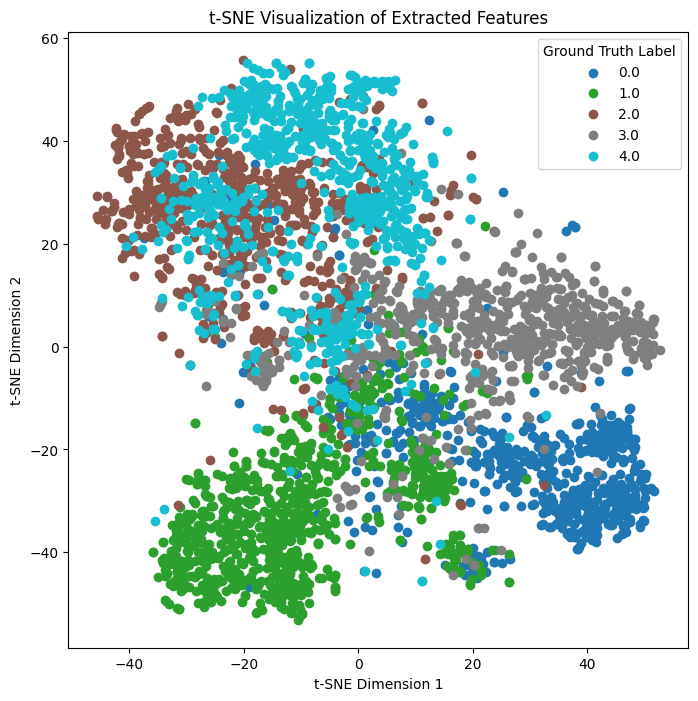

In [5]:

filename = './flowers_features_and_labels.npz'
data = np.load(filename)
f_all, y_all = data['f_all'], data['y_all']

# Initialize t-SNE with 2 output dimensions
tsne = TSNE(n_components=2, random_state=42)
# Fit and transform the features to 2D space
features_2d = tsne.fit_transform(f_all)

# Extract unique labels and corresponding colors
unique_labels = np.unique(y_all)
num_labels = len(unique_labels)
colors = plt.cm.tab10(np.linspace(0, 1, num_labels))  # Generate colors for each label

# Plot each data point with its label as color
plt.figure(figsize=(8, 8))
for i, label in enumerate(unique_labels):
    indices = (y_all == label)
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], color=colors[i], label=str(label))

plt.title('t-SNE Visualization of Extracted Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Ground Truth Label', loc='best')
plt.show()


Two most informative component of extracted features are capable of making distinction between four classes (0,1,2,3) of flower images. The fifth class (4) coincide with the rest of the classes especially with class number 2.

### Question 24
Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.

In [6]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [24]:
# Perform clustering without reduction of dimension
clusterer = KMeans(n_clusters=5, max_iter=1000,
        n_init=30, random_state=42)

labels_pred = clusterer.fit_predict(X_all)
ari = adjusted_rand_score(labels_true, labels_pred)
print('Rand Index when there is no reduction of dimension:', ari)

Rand Index when there is no reduction of dimension: 0.19121276376559876


In [13]:

def perform_clustering_with_reduction(reduction_method, clustering_method, X, labels_true, n_components=50):
    # Perform dimensionality reduction
    if reduction_method == 'SVD':
        reducer = TruncatedSVD(n_components=n_components, random_state=42)
        X_reduced = reducer.fit_transform(X)  # Apply reduction to the data
    elif reduction_method == 'UMAP':
        reducer = UMAP(n_components=n_components, random_state=42)
        X_reduced = reducer.fit_transform(X)  # Apply reduction to the data
    elif reduction_method == 'Autoencoder':
        autoencoder = Autoencoder(n_components=n_components)
        autoencoder.fit(X)
        X_reduced = autoencoder.transform(X)


    # Perform clustering
    if clustering_method == 'KMeans':
        clusterer = KMeans(n_clusters=5, max_iter=1000,
        n_init=30, random_state=42)
    elif clustering_method == 'Agglomerative':
        clusterer = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
    elif clustering_method == 'HDBSCAN':
        clusterer = hdbscan.HDBSCAN(min_cluster_size=10)

    labels_pred = clusterer.fit_predict(X_reduced)

    # Evaluate clustering performance using Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(labels_true, labels_pred)
    return ari

# List of dimensionality reduction and clustering methods to consider
reduction_methods = ['SVD', 'UMAP', 'Autoencoder']
clustering_methods = ['KMeans', 'Agglomerative', 'HDBSCAN']

# Load the pre-computed features and labels
filename = './flowers_features_and_labels.npz'
data = np.load(filename)
X_all, labels_true = data['f_all'], data['y_all']

# Perform clustering with each combination of reduction and clustering method
results = []
for reduction_method in reduction_methods:
    for clustering_method in clustering_methods:
        ari = perform_clustering_with_reduction(reduction_method, clustering_method, X_all, labels_true)
        results.append((reduction_method, clustering_method, ari))

# Display results
for reduction_method, clustering_method, ari in results:
    print(f"Reduction Method: {reduction_method}, Clustering Method: {clustering_method}, ARI: {ari}")


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Reduction Method: SVD, Clustering Method: KMeans, ARI: 0.19426467285950377
Reduction Method: SVD, Clustering Method: Agglomerative, ARI: 0.22825995103004965
Reduction Method: SVD, Clustering Method: HDBSCAN, ARI: 0.0
Reduction Method: UMAP, Clustering Method: KMeans, ARI: 0.4165509205988447
Reduction Method: UMAP, Clustering Method: Agglomerative, ARI: 0.3722445177451581
Reduction Method: UMAP, Clustering Method: HDBSCAN, ARI: -0.0007002455807158757
Reduction Method: Autoencoder, Clustering Method: KMeans, ARI: 0.22146499483979495
Reduction Method: Autoencoder, Clustering Method: Agglomerative, ARI: 0.2792462980642481
Reduction Method: Autoencoder, Clustering Method: HDBSCAN, ARI: 0.0


In [15]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

In [23]:
def perform_clustering_with_reduction(reduction_method, X, labels_true, n_components=50,
                                      min_cluster_size=10, min_samples=1):
    # Perform dimensionality reduction
    if reduction_method == 'SVD':
        reducer = TruncatedSVD(n_components=n_components, random_state=42)
        X_reduced = reducer.fit_transform(X)
    elif reduction_method == 'UMAP':
        reducer = UMAP(n_components=n_components, random_state=42)
        X_reduced = reducer.fit_transform(X)
    elif reduction_method == 'Autoencoder':
        autoencoder = Autoencoder(n_components=n_components)
        autoencoder.fit(X)
        X_reduced = autoencoder.transform(X)

    # Perform clustering with HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    labels_pred = clusterer.fit_predict(X_reduced)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
    n_noise_ = list(labels_pred).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)


    # Filter out noise points (labels_pred == -1)
    valid_indices = labels_pred != -1
    filtered_labels_true = labels_true[valid_indices]
    filtered_labels_pred = labels_pred[valid_indices]

    # Evaluate clustering performance using Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(filtered_labels_true, filtered_labels_pred)
    return ari

# List of dimensionality reduction methods to consider
reduction_methods = ['SVD', 'UMAP', 'Autoencoder']

# Load the pre-computed features and labels
filename = './flowers_features_and_labels.npz'
data = np.load(filename)
X_all, labels_true = data['f_all'], data['y_all']

# Define ranges for grid search
min_cluster_size_range = [80, 90, 100]
min_samples_range = [50]

# Perform clustering with each combination of reduction method and parameters
results = []
for reduction_method in reduction_methods:
    for min_cluster_size in min_cluster_size_range:
        for min_samples in min_samples_range:
            print(reduction_method, min_cluster_size, min_samples)
            ari = perform_clustering_with_reduction(reduction_method, X_all, labels_true,
                                                    min_cluster_size=min_cluster_size,
                                                    min_samples=min_samples)
            print ('ari:', ari)
            results.append((reduction_method, min_cluster_size, min_samples, ari))

# Find the best parameters based on maximum ARI
best_params = None
best_ari = -1
for reduction_method, min_cluster_size, min_samples, ari in results:
    if ari > best_ari:
        best_ari = ari
        best_params = (reduction_method, min_cluster_size, min_samples)




SVD 80 50
Estimated number of clusters: 0
Estimated number of noise points: 3670
ari: 1.0
SVD 90 50
Estimated number of clusters: 0
Estimated number of noise points: 3670
ari: 1.0
SVD 100 50
Estimated number of clusters: 0
Estimated number of noise points: 3670
ari: 1.0
UMAP 80 50
Estimated number of clusters: 5
Estimated number of noise points: 1312
ari: 0.6216258784907273
UMAP 90 50
Estimated number of clusters: 5
Estimated number of noise points: 1312
ari: 0.6216258784907273
UMAP 100 50
Estimated number of clusters: 5
Estimated number of noise points: 1312
ari: 0.6216258784907273
Autoencoder 80 50


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Estimated number of clusters: 0
Estimated number of noise points: 3670
ari: 1.0
Autoencoder 90 50


100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Estimated number of clusters: 0
Estimated number of noise points: 3670
ari: 1.0
Autoencoder 100 50


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


Estimated number of clusters: 0
Estimated number of noise points: 3670
ari: 1.0


### Question 24 (answer)
According to the result of above two cells, UMAP followed by HSBSCAN with min_samples=50 and min_cluster_size = 80 results in 5 clusters and 1312 data points detected as noise. The Rand score of 0.62 is achieved. On the other hand, other clustering methods cluster all the points and don't put aside some of the points as noise, therefore their score is lower. Among the other clustering methods, KMeans result in the highest Rand Score of 0.41 with all the points being clusterd.

## MLP classifier
### QUESTION 25:
Report the test accuracy of the MLP classifier on the original VGG features. Report the same when using the reduced-dimension features (you have freedom in choosing the dimensionality reduction algorithm and its parameters). Does the performance of the model suffer with the reduced-dimension representations? Is it significant? Does the success in classification make sense in the context of the clustering results obtained for the same features in Question 24.


In [21]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        # self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        # X = torch.tensor(X, dtype=torch.float32, device='cuda')
        # y = torch.tensor(y, dtype=torch.int64, device='cuda')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.int64)

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                optimizer.zero_grad()  # Zero out gradients
                outputs = self.model(X_)  # Forward pass
                loss = criterion(outputs, y_)  # Compute loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update model parameters

        return self

    def eval(self, X_test, y_test):
        # Convert inputs and labels to torch tensors and move to GPU
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.int64)

        self.model.eval()  # Set model to evaluation mode
        correct = 0

        # Evaluate the model on test data
        with torch.no_grad():  # Disable gradient computation
            outputs = self.model(X_test)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == y_test).sum().item()

        accuracy = correct / len(y_test)  # Calculate accuracy
        return accuracy

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, labels_true, test_size=0.4, random_state=0)

In [22]:
# test accuracy of the MLP classifier on the original VGG features
num_features = X_train.shape[1]
model = MLP(num_features)
model.train(X_train, y_train)
accuracy = model.eval(X_test, y_test)  # Evaluate the model on test data
print(f"Test Accuracy: {accuracy:.4f}")


100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


Test Accuracy: 0.8999


In [23]:
# test accuracy of the MLP classifier when using the UMAP reduced-dimension features
reducer = UMAP(n_components=50, random_state=42)
X_train_reduced = reducer.fit_transform(X_train)
num_features = X_train_reduced.shape[1]
model = MLP(num_features)
model.train(X_train_reduced, y_train)

X_test_reduced = reducer.transform(X_test)
accuracy = model.eval(X_test_reduced, y_test)  # Evaluate the model on test data
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Test Accuracy: 0.7800


### QUESTION 25 (answer):
The success in classification and clustering can have differing outcomes when utilizing reduced dimensions of the same feature set. In this context, we observed a decrease in the test accuracy of the classification model when using reduced dimensions, from 89% to 78%. This decrease of 10% in accuracy indicates that the performance of the classification model was notably impacted by the dimensionality reduction.

Conversely, the behavior of the clustering model varied with the reduction in feature dimensions. The Adjusted Rand Index (ARI) for clustering, which measures the agreement between true class labels and cluster assignments, improved significantly from 0.19 to 0.41 when reducing the dimensionality of the feature set.

These contrasting results highlight an important distinction between classification and clustering tasks concerning the impact of feature dimensionality. While clustering benefited from the reduced dimensionality, as evidenced by the improved ARI, the classification model's performance suffered. This discrepancy underscores the nuanced relationship between feature representation, model complexity, and task-specific requirements in machine learning.